# 1. Deep Q-Learning for Navigation
---

In this notebook I will solve the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) using Deep Q-Learning as described in [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).  In follow up notebooks I'll improve on this solution.  See the [README](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/README.md) for instructions on how to setup your environment to run the code here.

Our base code for the [DQN-Agent](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/dqn_agent.py), [Model](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/model.py) and [trainer](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/trainer.py) are taken directly from the [course solution](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution) to the [Deep Q-Learning Coding Exercise](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).  To solve the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) I just need to import the agent and trainer, instantiate the agent with the appropriate state and action sizes, and train for about 500 episodes.

In [1]:
%%time

from dqn_agent import Agent
from trainer import train
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="./data/Banana.app")
agent = Agent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.49
Episode 200	Average Score: 3.90
Episode 300	Average Score: 7.40
Episode 400	Average Score: 9.89
Episode 500	Average Score: 12.76
Episode 525	Average Score: 13.05
Environment solved in 425 episodes!	Average Score: 13.05


<Figure size 640x480 with 1 Axes>

CPU times: user 3min 26s, sys: 23 s, total: 3min 49s
Wall time: 7min 25s


So the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector)
was solved in under 500 episodes! Not bad at all.  

Below is a plot of the scores.

Text(0.5, 0, 'Episode #')

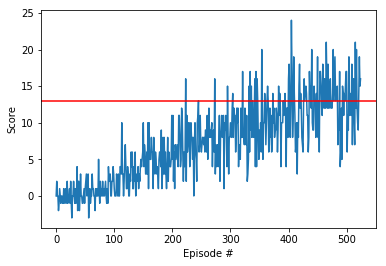

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.axhline(y=13, color='r', linestyle='-')
plt.ylabel('Score')
plt.xlabel('Episode #')